In [503]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

pd.set_option("display.max_columns",30)

In [586]:
barbados_processed_df = pd.read_csv("station_data_processed/marshall_hourly_processed_data.csv", index_col=0)
barbados_processed_df.index = pd.to_datetime(barbados_processed_df.index, errors='coerce')



In [587]:
barbados_processed_df.describe()

,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,bme_slp,bme_alt,bme_hum,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
count,2.413617e+06,2.414535e+06,2.413942e+06,2409843.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.612900e+06,2.400251e+06,2.551416e+06,2.759821e+06,1.735939e+06,1.749167e+06,1.736749e+06,2.762346e+06,2.692444e+06
mean,1.118363e+01,8.224099e+02,1.010259e+03,1743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.151809e+01,4.692207e+01,1.087879e+01,6.877982e-04,6.011301e+02,3.866441e+03,1.872449e+02,1.445796e+02,1.391728e+00
std,1.063827e+01,1.924599e+01,2.409141e+01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.057538e+01,2.364455e+01,1.061440e+01,7.311341e-02,2.881190e+02,2.904967e+03,1.460509e+02,1.208759e+02,1.780924e+00
min,-3.680000e+01,3.069000e+02,3.663300e+02,1743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.950000e+01,1.000000e-01,-3.470000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.300000e+00,8.210200e+02,1.005980e+03,1743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.700000e+00,2.820000e+01,3.100000e+00,0.000000e+00,2.630000e+02,2.800000e+02,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.170000e+01,8.251000e+02,1.012180e+03,1743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.200000e+01,4.350000e+01,1.110000e+01,0.000000e+00,6.530000e+02,4.325000e+03,2.120000e+02,1.494000e+02,8.500000e-01
75%,1.930000e+01,8.285400e+02,1.018980e+03,1743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.950000e+01,6.480000e+01,1.890000e+01,0.000000e+00,8.650000e+02,6.621000e+03,3.260000e+02,2.507000e+02,2.110000e+00
max,4.500000e+01,1.097700e+03,1.353760e+03,1743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.490000e+01,9.990000e+01,4.390000e+01,2.880000e+01,1.919000e+03,1.515500e+04,9.660000e+02,3.600000e+02,9.955000e+01


In [588]:
def statistics(df, hourly = False): 
    # turn objec index into datetime index
    df.index = pd.to_datetime(df.index)

    df = df.sort_index()

    if hourly:
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')  # min stands for minute frequency
        time_unit  = "hour"
    else:
        # Create a complete minute-wise index
        full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='min')  # min stands for minute frequency
        time_unit  = "minute"
    
    # Reindex the dataframe to include all minutes, filling missing with NaN
    df = df.reindex(full_index) 

    # Total timespan/steps
    total_time = full_index.shape[0]

    # Actual measurements not Nan
    actual_measurements = df.notna().sum()
    relative_measurements = actual_measurements / total_time * 100

    # Non - zero measurments 
    zero_measurements = (df == 0).sum()
    nan_count = df.isna().sum()
    
    non_zero_measurements = actual_measurements - zero_measurements
    relative_non_zero_measurements = non_zero_measurements / total_time * 100
    nonzerorelativetoactual = non_zero_measurements / actual_measurements * 100
    
    print(f"Total {time_unit}s: {total_time}")
    print(f"Total {time_unit}s: 100%")
    print(f"Actual measurements: {actual_measurements}")
    print(f"Relative measurements: {relative_measurements:.2f}%")
    print(f"Non-zero measurements: {non_zero_measurements}")
    print(f"Relative non-zero measurements: {relative_non_zero_measurements:.2f}%")
    print(f"Non-zero relative to actual: {nonzerorelativetoactual:.2f}%")
    print(f"Zero measurements: {zero_measurements}")
    print(f"NaN measurements: {nan_count}")

In [589]:
def plot_hist(df, var_name, station, save=False):

    staion_name = station
    # Create a histogram with log scale on the y-axis
    
    plt.figure(figsize=(14,6) )
    plt.hist(df[var_name], bins=50, log=False, color='mediumblue', edgecolor='black')     

    # Add labels and title
    plt.xlabel(f"{var_name.capitalize()} Bins")
    plt.ylabel("Count (Log Scale)")
    plt.title(f"{station.capitalize()}: Histogram of {var_name.capitalize()} with Log Scale")
    plt.grid(True)

    if save:
    # Check if the 'eda' directory exists, if not, create it
        save_dir = "eda"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        plt.savefig(f"eda/{staion_name}_{var_name}_hist.png")
        print(f"Figure saved as eda/{staion_name}_{var_name}_hist.png")

    # Display the plot
    plt.show()





In [590]:
summary = statistics(barbados_processed_df["mcp9808"])


Total minutes: 3549033
Total minutes: 100%
Actual measurements: 2551416
Relative measurements: 71.89%
Non-zero measurements: 2538878
Relative non-zero measurements: 71.54%
Non-zero relative to actual: 99.51%
Zero measurements: 12538
NaN measurements: 997617


Figure saved as eda/marshall_minutely_mcp9808_hist.png


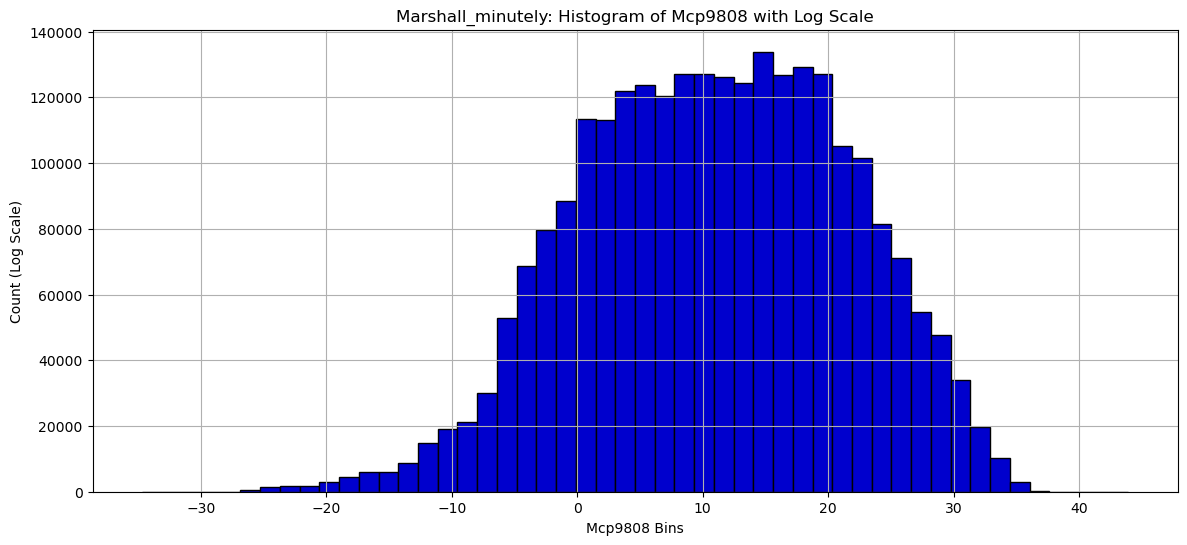

In [591]:
plot_hist(barbados_processed_df, "mcp9808", "marshall_minutely", save=True)

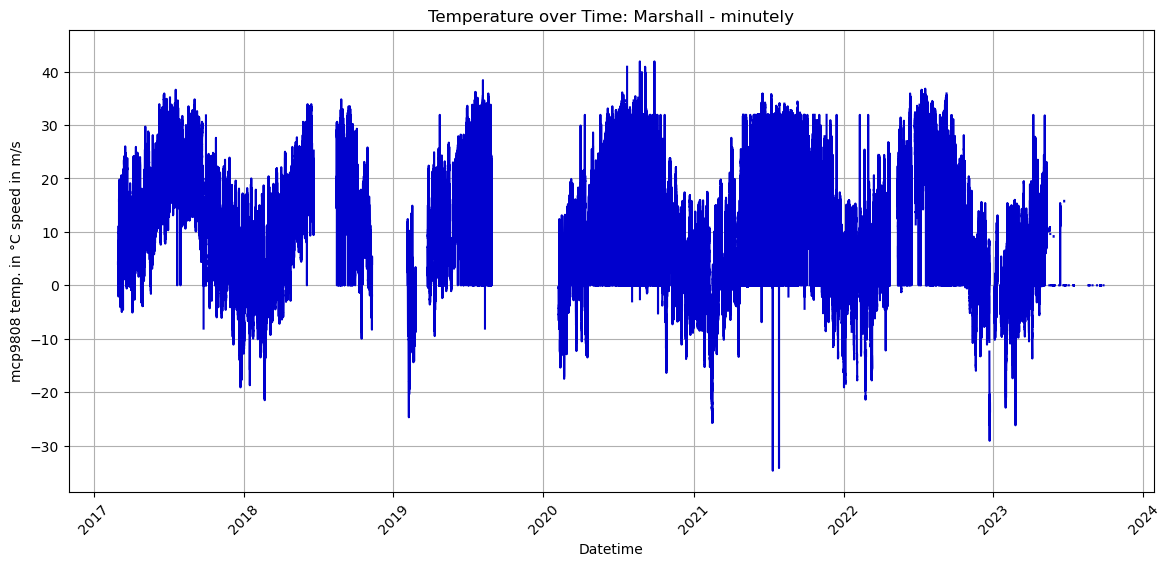

In [592]:
plt.figure(figsize=(14,6) )
plt.plot(barbados_processed_df["mcp9808"], color='mediumblue')
plt.xlabel("Datetime")
plt.ylabel("mcp9808 temp. in °C speed in m/s") 
plt.title("Temperature over Time: Marshall - minutely")
plt.xticks(rotation=45)
plt.grid(True)

plt.savefig("eda/marshall_mcp9808_minutely_plot.png")

plt.show()

In [568]:
def circular_mean(series):
    """
    Calculate the mean direction for circular data (e.g., wind direction).
    """
    radians = np.deg2rad(series.dropna())
    sin_mean = np.nanmean(np.sin(radians))
    cos_mean = np.nanmean(np.cos(radians))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    mean_angle_deg = np.rad2deg(mean_angle)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

def custom_aggregation(var_name):
    """
    Define custom aggregation functions for different variables during resampling.
    """
    def aggregate(series):
        # Exclude if the series has too many missing values
        if series.isna().sum() > 20:
            return np.nan
        # Exclude if the series has fewer than 3 unique values (except for 'tipping')
        if var_name != 'tipping' and series.nunique() <= 3:
            return np.nan
        if var_name == "mcp9808": 
            series = series.replace(0.00, np.nan)

            

        if var_name == 'tipping':
            # Sum for precipitation
            return series.sum()
        elif var_name == 'wind_speed':
            # Mean for wind speed
            return series.mean()
        elif var_name == 'wind_dir':
            # Circular mean for wind direction
            return circular_mean(series)
        else:
            # Median for other variables
            return series.median()
    return aggregate

aggregation_dict = {'bmp180_temp': "mean",
                    'bmp180_pres': "mean",
                    'bmp180_slp': "mean",
                    'bmp180_alt': "mean",
                    'bmp280_temp': "mean",
                    'bmp280_pres': "mean",
                    'bmp280_slp': "mean",
                    'bmp280_alt': "mean",
                    'bme_temp': "mean",
                    'bme_pres': "mean",
                    'bme_slp': "mean",
                    'bme_alt': "mean",
                    'bme_hum': "mean",
                    'htu_temp': "mean",
                    'htu_hum': "mean",
                    'mcp9808': "mean",
                    'tipping': "sum",
                    'vis_light': "mean",
                    'ir_light': "mean",
                    'uv_light': "mean",
                    'wind_dir': "mean",
                    'wind_speed': "mean"}

In [593]:
hourly_df = pd.DataFrame()

for var_name in barbados_processed_df.columns:
    hourly_series = barbados_processed_df[var_name].resample('h').apply(custom_aggregation(var_name))
    hourly_df[var_name] = hourly_series

In [594]:
hourly_df

,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,bme_slp,bme_alt,bme_hum,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,,,,,,,,,,,
2017-03-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,349.383765,0.622000
2017-03-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 15:00:00,5.30,821.250,1012.860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.7,NaN,NaN,0.0,NaN,NaN,NaN,253.115772,0.827627
2023-11-29 16:00:00,9.20,820.700,1009.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,NaN,NaN,0.0,NaN,NaN,NaN,112.725353,1.082069
2023-11-29 17:00:00,9.40,820.355,1008.645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.7,NaN,NaN,0.0,NaN,NaN,NaN,12.820698,1.316724


In [595]:
summary = statistics(hourly_df["mcp9808"], hourly=True)


Total hours: 59151
Total hours: 100%
Actual measurements: 42001
Relative measurements: 71.01%
Non-zero measurements: 41988
Relative non-zero measurements: 70.98%
Non-zero relative to actual: 99.97%
Zero measurements: 13
NaN measurements: 17150


Figure saved as eda/marshall_hourly_mcp9808_hist.png


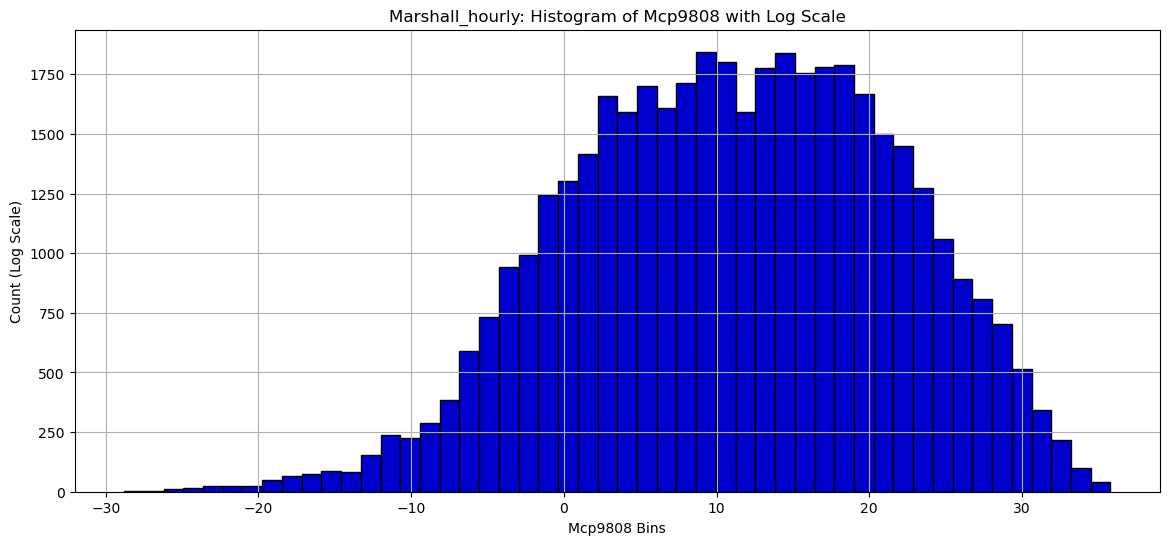

In [596]:
plot_hist(hourly_df, "mcp9808", "marshall_hourly", save=True)


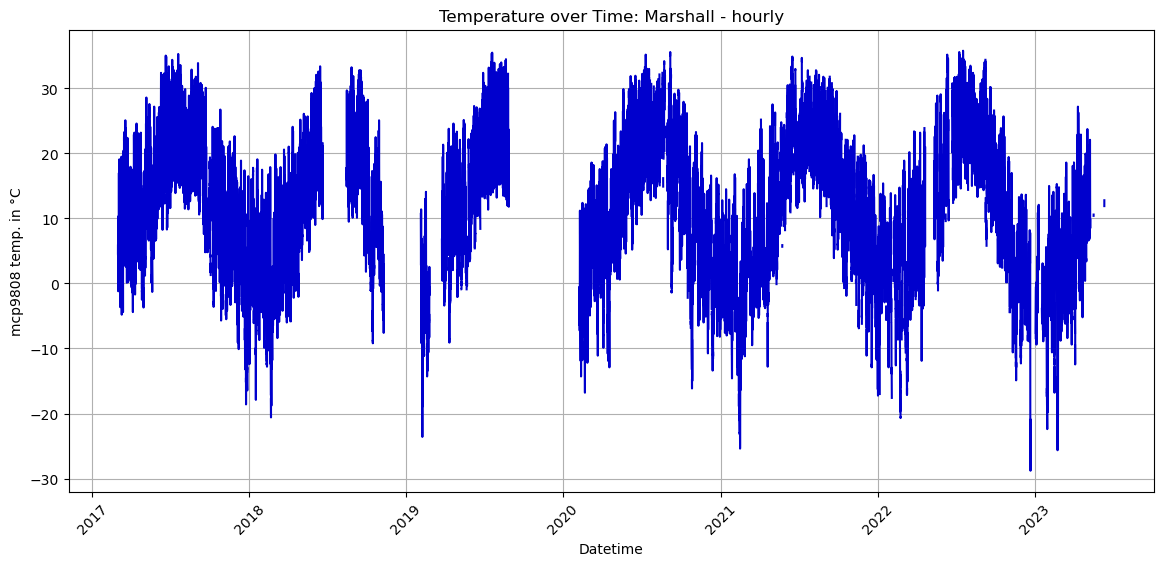

In [597]:
plt.figure(figsize=(14,6) )
plt.plot(hourly_df["mcp9808"], color='mediumblue')
plt.xlabel("Datetime")
plt.ylabel("mcp9808 temp. in °C")
plt.title("Temperature over Time: Marshall - hourly")
plt.xticks(rotation=45)
plt.grid(True)

plt.savefig("eda/marshall_mcp9808_hourly_plot.png")

plt.show()

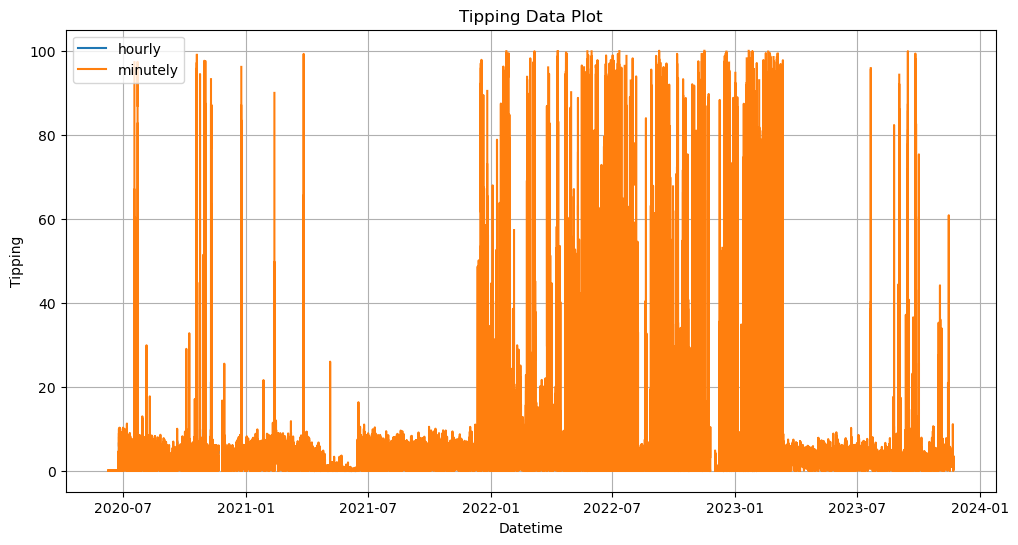

In [517]:
plt.figure(figsize=(12,6) )
plt.plot(hourly_df["wind_speed"], label="hourly")


plt.plot(barbados_processed_df["wind_speed"], label="minutely")

plt.xlabel("Datetime")
plt.ylabel("Tipping")
plt.title("Tipping Data Plot")
plt.legend()
plt.grid(True)




plt.show()

In [518]:
summary = statistics(hourly_df["tipping"], hourly=True)


Total hours: 30293
Total hours: 100%
Actual measurements: 29008
Relative measurements: 95.76%
Non-zero measurements: 2868
Relative non-zero measurements: 9.47%
Non-zero relative to actual: 9.89%
Zero measurements: 26140
NaN measurements: 1285


In [519]:
hourly_df.tail()

,bmp180_temp,bmp180_pres,bmp180_slp,bmp180_alt,bmp280_temp,bmp280_pres,bmp280_slp,bmp280_alt,bme_temp,bme_pres,bme_slp,bme_alt,bme_hum,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,,,,,,,,,,,
2023-11-22 15:00:00,NaN,NaN,NaN,NaN,28.66,982.875,1013.750,NaN,NaN,NaN,NaN,NaN,NaN,10.4,NaN,27.30,0.0,845.0,6304.5,315.0,NaN,2.128167
2023-11-22 16:00:00,NaN,NaN,NaN,NaN,29.05,982.170,1012.980,NaN,NaN,NaN,NaN,NaN,NaN,11.6,NaN,27.60,0.0,923.0,7158.5,356.5,NaN,2.052167
2023-11-22 17:00:00,NaN,NaN,NaN,NaN,28.84,981.645,1012.470,NaN,NaN,NaN,NaN,NaN,NaN,11.7,NaN,27.40,0.0,730.0,5044.5,253.5,NaN,2.274000
2023-11-22 18:00:00,NaN,NaN,NaN,NaN,28.37,981.230,1012.085,NaN,NaN,NaN,NaN,NaN,NaN,11.6,NaN,26.95,0.0,589.0,3605.0,178.0,NaN,2.291500
2023-11-22 19:00:00,NaN,NaN,NaN,NaN,28.48,981.090,1011.920,NaN,NaN,NaN,NaN,NaN,NaN,11.5,NaN,27.00,0.0,554.0,3272.0,159.0,NaN,2.121905


In [520]:
hourly_series = barbados_raw_df["tipping"].resample('h').apply(custom_aggregation('tipping'))
hourly_series

NameError: name 'barbados_raw_df' is not defined